In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector=inspect(engine)
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session=Session(bind=engine)

# Exploratory Climate Analysis

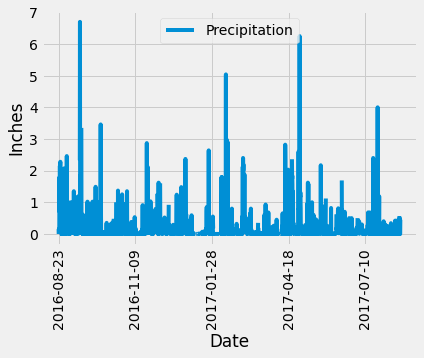

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
from datetime import datetime
latest_date=session.query(Measurement.date, func.max(Measurement.date)).scalar()

    
date_format=datetime.strptime(latest_date, '%Y-%m-%d')
date_format
year_ago= date_format - dt.timedelta(days=365.5)
year_ago

# Perform a query to retrieve the data and precipitation scores
latest_year= session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()
latest_year

# Save the query results as a Pandas DataFrame and set the index to the date column
date=[]
precipitation=[]
for record in latest_year:
    date.append(record[0])
    precipitation.append(record[1])
    
# Sort the dataframe by date
latest_pr=pd.DataFrame({"Date":date, "Precipitation":precipitation})
latest_pr=latest_pr.sort_values(by=['Date'])
latest_pr.head()

# Use Pandas Plotting with Matplotlib to plot the data
ax=latest_pr.plot("Date","Precipitation",rot = 90)
ax.set_ylabel('Inches')
plt.savefig("images/Precipitation.png")
plt.show()

In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
latest_pr.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Measurement.station)).scalar()
station_count

19550

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_list= session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_list


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
#Most active station
active_station_id=station_list[0][0]
active_station_id

'USC00519281'

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == active_station_id).scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == active_station_id).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == active_station_id).scalar()
print(f"Lowest temperature: {lowest_temp}, Highest Temperature: {highest_temp}, Average Temperature:{avg_temp}")

Lowest temperature: 54.0, Highest Temperature: 85.0, Average Temperature:71.66378066378067


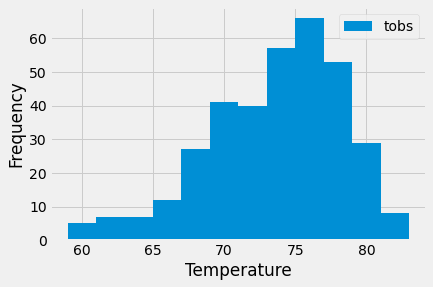

In [53]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_year_obs= session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == active_station_id).all()
latest_obs_df=pd.DataFrame(latest_year_obs)
latest_obs_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.savefig("images/tobs.png")
plt.show()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
   
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [57]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start=datetime.strptime('2017-01-01', '%Y-%m-%d')
trip_start_year_ago=trip_start-dt.timedelta(days=365) 
trip_end=datetime.strptime('2017-01-15', '%Y-%m-%d')
trip_end_year_ago=trip_end-dt.timedelta(days=365)

results=calc_temps(trip_start_year_ago,trip_end_year_ago )
print(results)

[(62.0, 69.73170731707317, 78.0)]


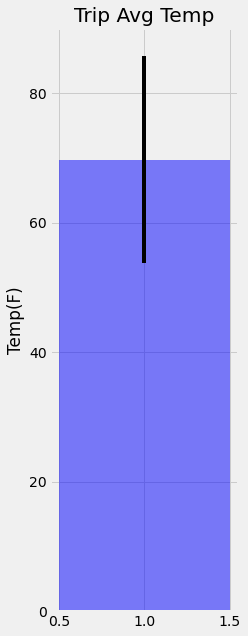

In [58]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = results[0][0]
tavg = results[0][1]
tmax = results[0][2]
y_err = tmax-tmin

plt.figure(figsize=(3,10))
plt.bar(1,tavg,yerr=y_err,align="center",width=1,color="blue",alpha=0.5)
plt.ylim=(0,100)
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.savefig('images/Trip Avg Temp.png')
plt.show()

In [59]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall=session.query(Measurement.station, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= trip_start_year_ago).\
    filter(Measurement.date >= trip_end_year_ago).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp)).all()
rainfall


[('USC00517948', 6.359999999999999),
 ('USC00519397', 26.570000000000004),
 ('USC00514830', 48.35),
 ('USC00519523', 57.95999999999999),
 ('USC00513117', 86.12999999999991),
 ('USC00519281', 122.47000000000013),
 ('USC00516128', 228.71999999999997)]

In [60]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [97]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start
trip_end
# Use the start and end date to create a range of dates
date_range=session.query(Measurement.date).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).all()

# Stip off the year and save a list of %m-%d strings
trip_dates= [x[0] for x in date_range]
trip_dates
trip_m_d=[x[5:]for x in trip_dates]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
delta = trip_start-trip_end
dates = []
for i in range(delta.days+1):
    date = start_date + dt.timedelta(days=i)
    dates.append(dt.datetime.strftime(date, "%Y-%m-%d"))
    tmin,tavg,tmax = np.ravel(daily_normals(dt.datetime.strftime(date, "%m-%d")))
    normals.append((tmin,tavg,tmax))



In [101]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_DF = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=dates)


In [103]:
# Plot the daily normals as an area plot with `stacked=False`
